# JHU covid-19 analysis
See daily increase of cases and deaths per US state. 

To do: 
- fix bump around March 12
- daily cases curve

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta

import datetime
import pytz
from tzwhere import tzwhere
 

import JHUprocessing as jp

from matplotlib.dates import date2num       #-->Update
state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

# load daily reports 

In [2]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0)
#     print(file) 
    df = df.append(df_temp, sort=True) 
    
# convert both separately 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   # 
    
# df['Country/Region'].isnull().sum() + df['Country/Region'].notnull().sum()
# df['Country_Region'].notnull().sum()
df['Country/Region'].isnull().sum()

cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 


cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 


cond = df['Latitude'].isnull()
df['Lat'] = df['Lat'].where(cond, df['Latitude'] ) 

cond = df['Longitude'].isnull()
df['Long_'] = df['Long_'].where(cond, df['Longitude'] ) 


cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 


df = df.drop( columns = ['Last_Update','Country_Region','Province_State','Admin2','FIPS',])
df['Last Update'] = pd.to_datetime(df['Last Update'] , unit='D'   )

# df['Date'] = df['Last Update'].dt.date
df['Datetime'] = df['Last Update'] 

col_order = ['Datetime','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered','Combined_Key' ]
df = df[col_order]

df.tail()

,Datetime,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key
3429,2020-03-29 23:08:13,Venezuela,NaN,78.0,119.0,2.0,39.0,Venezuela
3430,2020-03-29 23:08:13,Vietnam,NaN,163.0,188.0,0.0,25.0,Vietnam
3431,2020-03-29 23:08:13,West Bank and Gaza,NaN,90.0,109.0,1.0,18.0,West Bank and Gaza
3432,2020-03-29 23:08:13,Zambia,NaN,29.0,29.0,0.0,0.0,Zambia
3433,2020-03-29 23:08:13,Zimbabwe,NaN,6.0,7.0,1.0,0.0,Zimbabwe


# create US only frame

In [3]:
bool_US = df['Country/Region'] =='US'
df_US = df[bool_US ]
df_US.head() # .groupby('Date (UTC)').sum().tail(15)

,Datetime,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key
31,2020-01-22 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN
31,2020-01-23 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN
33,2020-01-24 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN
34,2020-01-24 17:00:00,US,Chicago,NaN,1.0,NaN,NaN,NaN
33,2020-01-25 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN


In [4]:
# df_US['Province/State'].unique()

# remove from diamond princess

In [5]:
# bool_Dprincess = df_US['Province/State'].str.contains( 'CA (From Diamond Princess)' , regex=False)

# print('df_US shape: ' , df_US.shape)
# df_US.drop( df_US[bool_Dprincess].index, inplace=True) 
# print('df_US shape: ' , df_US.shape)

# bool_Dprincess.sum() 
# df_US.head() 

# Create state entry

In [6]:

error_dict = {'Chicago':'Illinois',
            'NE (From Diamond Princess)':'Diamond Princess',
            'CA (From Diamond Princess)':'Diamond Princess',
            'TX (From Diamond Princess)':'Diamond Princess',
            'Unassigned Location (From Diamond Princess)':'Diamond Princess',
            'D.C.':'District of Columbia',
            'Puerto Rico':'Other',
            'Guam':'Other',
            'U.S.':'Other',
            'US':'Other',
            'Virgin Islands':'Other',
            'United States Virgin Islands':'Other',
            'Wuhan Evacuee':'Other',
            'American Samoa':'Other',
            'Northern Mariana Islands':'Other',
#             'Northern Mariana Islands':'Other',
            'OR ':'Oregon'} 


def replace_state( x):
    state_entry = x['Province/State'].split(", ")[-1] 
    if state_entry in state_dict.keys(): 
        new = state_dict[state_entry]  
    elif state_entry in error_dict.keys():
        new = error_dict[state_entry]  
    else:
        new = state_entry   
    return new 
         
df_US.loc[:,'State'] = df_US.apply(replace_state, axis=1)
 

df_US['State'].unique()
# df_US.head()

 

D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\D_program_files\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array(['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Diamond Princess', 'Oregon',
       'Rhode Island', 'New Hampshire', 'Florida', 'New York', 'Georgia',
       'North Carolina', 'New Jersey', 'Nevada', 'Tennessee', 'Maryland',
       'Colorado', 'Pennsylvania', 'Kentucky', 'Indiana', 'Minnesota',
       'Grand Princess Cruise Ship', 'Connecticut', 'South Carolina',
       'Utah', 'Hawaii', 'Oklahoma', 'Virginia', 'District of Columbia',
       'Kansas', 'Missouri', 'Vermont', 'Iowa', 'Louisiana',
       'Grand Princess', 'Ohio', 'Alaska', 'Arkansas', 'Delaware',
       'Idaho', 'Maine', 'Michigan', 'Mississippi', 'Montana',
       'New Mexico', 'North Dakota', 'South Dakota', 'West Virginia',
       'Wyoming', 'Alabama', 'Other', 'Recovered'], dtype=object)

# Create date 

In [7]:
df_US.loc[:,'Date'] = (df_US['Datetime']- timedelta(hours = 7)  ).dt.date
df_US.loc[:,'Date'] = df_US['Datetime'].dt.date
df_US.head() 

,Datetime,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key,State,Date
31,2020-01-22 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN,Washington,2020-01-22
31,2020-01-23 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN,Washington,2020-01-23
33,2020-01-24 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN,Washington,2020-01-24
34,2020-01-24 17:00:00,US,Chicago,NaN,1.0,NaN,NaN,NaN,Illinois,2020-01-24
33,2020-01-25 17:00:00,US,Washington,NaN,1.0,NaN,NaN,NaN,Washington,2020-01-25


# find day 0

In [8]:
df_state =  df_US.groupby(['State','Date']).sum().reset_index()
 
df_day0 = pd.DataFrame()

# set thresholds for day 0 
threshold_cases = 1e3
threshold_deaths = 25

# find which countries are above the threshold
df_day =  df_state.groupby(['State','Date']).max().reset_index() 

df_day = df_day[ df_day['Confirmed'] > threshold_cases ]

threshold_states =  df_day['State'].unique().tolist()
# threshold_states.remove('Diamond Princess')
# threshold_states.remove('Grand Princess')
# threshold_states.remove('Other')

for country in threshold_states: 
    # df_temp contains only one country
    bool_country = df_state['State'] == country  
    df_temp = df_state[bool_country].copy()
    
    # find first day above threshold cases
    bool_threshold_cases = df_temp['Confirmed'] >= threshold_cases
    day0 = df_temp['Date'][bool_threshold_cases].iloc[0]
    
    # 
    newdays = (df_temp['Date'] - day0).dt.days 
    df_temp.loc[:,'Delta C'] = newdays
     
    bool_threshold_death = df_temp['Deaths'] >= threshold_deaths
    if bool_threshold_death.sum() > 0:
        day0 = df_temp['Date'][bool_threshold_death].iloc[0]
        newdays = (df_temp['Date'] - day0).dt.days
    else:
        newdays = np.zeros( np.shape(bool_threshold_death) ) 
    df_temp.loc[:,'Delta D'] = newdays
    
    df_day0 = df_day0.append(df_temp)   
    
df_day0.head(5)

,State,Date,Active,Confirmed,Deaths,Recovered,Delta C,Delta D
79,California,2020-01-26,0.0,2.0,0.0,0.0,-54,-56.0
80,California,2020-01-27,0.0,2.0,0.0,0.0,-53,-55.0
81,California,2020-01-28,0.0,2.0,0.0,0.0,-52,-54.0
82,California,2020-01-29,0.0,2.0,0.0,0.0,-51,-53.0
83,California,2020-01-30,0.0,2.0,0.0,0.0,-50,-52.0


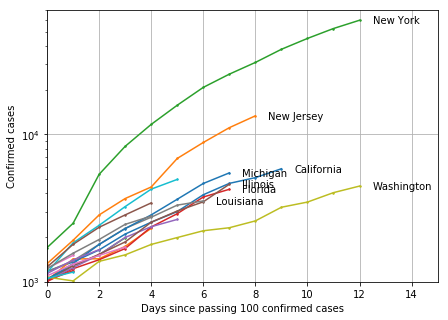

In [21]:
fig, ax = plt.subplots(1,1 ,figsize=(7,5))

# states = df_state['State'].unique()
for state in threshold_states:
    bool_state = df_day0['State'] == state 
    df_pl = df_day0[bool_state] 
    ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],'.-' ,ms=3,lw=1.5, label=state )
     
    y = df_pl['Confirmed'].iloc[-1]*0.95
    x = df_pl['Delta C'].iloc[-1] + 0.5
    if x > 6:
        ax.annotate( state ,[x,y])
    
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
# ax.set_title('Number of Cases in top countries (last update: ' + str( df_pl['Date'].iloc[-1]) + ')' ) 
# ax.set_xlim([0,70])

ax.set_xlim([0,15])
ax.set_ylim([1000,.7e5])

ax.set_xlabel("Days since passing 100 confirmed cases") 
ax.set_ylabel("Confirmed cases") 

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_states_caseslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

# inspect a particular state

In [10]:
# bool_statec = df['Province/State'] =='California' 
# bool_statec = df['Province/State'].str.contains( 'California' )
df['Date test'] = df['Datetime'] .dt.date
# df['Date test'] = (df['Datetime'] - timedelta(hours = 4)  ) .dt.date
bool_statec = df['Province/State'].str.contains( 'CA|California' )
# bool_statec = df['Province/State'].str.contains( 'Princess' )
bool_low = df['Datetime'] > datetime.datetime(2020,3,6)
bool_high = df['Datetime'] < datetime.datetime(2020,3,13) 
bool_intime = bool_low & bool_high

df[bool_statec & bool_intime]
df[bool_statec & bool_intime].groupby('Date test').sum() 


# bool_statec = df_US['State'] =='California' 

# bool_low = df_US['Date'] > datetime.datetime(2020,3,6).date()
# bool_high = df_US['Date'] < datetime.datetime(2020,3,13).date()
# bool_intime = bool_low & bool_high

# df_US[bool_statec & bool_intime]
# df_US[bool_statec & bool_intime].groupby('Date').sum() 

,Active,Confirmed,Deaths,Recovered
Date test,,,,
2020-03-06,0.0,38.0,3.0,0.0
2020-03-07,0.0,65.0,0.0,1.0
2020-03-08,0.0,150.0,0.0,2.0
2020-03-09,0.0,15.0,1.0,0.0
2020-03-10,0.0,144.0,2.0,2.0
2020-03-11,0.0,459.0,7.0,8.0
2020-03-12,0.0,221.0,4.0,6.0


# add measures to dataframe 

In [11]:
# df_state = df_state.drop( columns=['Measure', 'Measures'])
df_m = pd.read_csv( "measures_per_state.csv", index_col=None ) 
df_m['Date'] = pd.to_datetime( df_m['Date'] ).dt.date 

# add measures to additional column
for i,row in df_m.iterrows(): 
    state = row['State']
    date = row['Date']
    bool_loc = (df_state['State'] == state) & (df_state['Date'] == date) 
    df_state.loc[bool_loc,'Measure'] = row['Measure']
    
df_m.head()

,State,Date,Measure
0,Alabama,2020-03-18,Schools closed
1,Alabama,2020-03-28,Lockdown
2,California,2020-03-16,Local Lockdown
3,California,2020-03-19,Lockdown
4,Illinois,2020-03-17,Schools closed


# add missing dates

In [12]:
df_test = df_state.copy()

dates_unique =   df_test['Date'].unique()
dates = df['Datetime'].dt.date.unique()
state_list =  df_test['State'].unique()  

# df_temp = df_delta[bool_state].copy()

# # find missing dates 
for state in state_list:
#     bool_state = df_test['State'] == state 
    for date in dates:
        bool_state = df_test['State'] == state 
        subframe = df_test.loc[bool_state,'Date'].tolist() 
        if date not in subframe : 
            append_series = pd.Series({'State':state,'Date':date,'Active':0,'Confirmed':0,'Deaths':0,'Recovered':0})
            df_test = df_test.append( append_series, ignore_index=True)
  
subframe
bool_state = df_test['State'] == 'Alabama'
df_test[bool_state].sort_values(by=['Date'])
 
    
df_test = df_test.sort_values( by=['State','Date']).reset_index(drop=True) 
# datetime.datetim  
df_test.head()

,State,Date,Active,Confirmed,Deaths,Recovered,Measure
0,Alabama,2020-01-22,0.0,0.0,0.0,0.0,NaN
1,Alabama,2020-01-23,0.0,0.0,0.0,0.0,NaN
2,Alabama,2020-01-24,0.0,0.0,0.0,0.0,NaN
3,Alabama,2020-01-25,0.0,0.0,0.0,0.0,NaN
4,Alabama,2020-01-26,0.0,0.0,0.0,0.0,NaN


In [13]:
df_delta = df_test.copy() 
    
df_delta['Daily Confirmed'] = np.nan
df_delta['Daily Deaths'] = np.nan

days = df_delta['Date'].unique()  

bool_day0 = df_delta['Date'] == days[0]
df_delta.loc[bool_day0,'Daily Confirmed'] = 0
df_delta.loc[bool_day0,'Daily Deaths'] = 0
 
for day in days[1:]:     
    
    bool_day = df_delta['Date'] == day 
    bool_prior = df_delta['Date'] == ( day- timedelta(days=1))  

    delta = df_delta[bool_day]['Confirmed'].values - df_delta[bool_prior]['Confirmed'].values
    df_delta.loc[bool_day,'Daily Confirmed'] = delta 
    
    
    delta = df_delta[bool_day]['Deaths'].values - df_delta[bool_prior]['Deaths'].values
    df_delta.loc[bool_day,'Daily Deaths'] = delta 
     
df_delta['Date']  = df_delta['Date'].apply(date2num)      #-->Update


In [14]:
def smooth(x,window_len=11,window='hanning'):
  
    # ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y  

def plot_daily( ax_p, date_col, data_series, measures = pd.DataFrame()):
    
    # plotting parameters 
    bar_alpha = 0.3
    filter_w = 9
    filter_w_delay = 13

    case_delay = 11
    death_delay = 13

    edge_cut = int( np.floor(filter_w/2) ) 
    edge_cut_delay = int( np.floor(filter_w_delay/2) )  
    
    weeks = mdates.DayLocator(bymonthday=[1,11,21], interval=1, tz=None)
    months_fmt = mdates.DateFormatter('%m-%d') 
    #------------------------------------------------------

    # smoothen data
    plot_data =  data_series.values 
    plot_data_fake = np.append( plot_data, plot_data[-1]*np.ones((2)) )
    plot_smooth = smooth( plot_data_fake ,filter_w,'hamming' )[edge_cut:-edge_cut-2]
    plot_smooth_delay = smooth( plot_data_fake ,filter_w_delay,'hamming' )[edge_cut_delay:-edge_cut_delay-2]
    
    # plot data
    ax_p.bar( date_col,  plot_data   , alpha = bar_alpha ,
                label = 'Reported cases') 
    ax_p.plot( date_col, plot_smooth)
    ax_p.plot( date_col.iloc[0:-case_delay] , plot_smooth_delay[case_delay:] )
    ax_p.fill_between( date_col.iloc[0:-case_delay] , 0, plot_smooth_delay[case_delay:] ,
                      alpha= bar_alpha, label='Estimated cases'
                    )

    # axis modify
    ax_p.xaxis_date()
    ax_p.xaxis.set_major_locator(weeks)
    ax_p.xaxis.set_major_formatter(months_fmt)  
 
    cmax = plot_smooth.max()*1.2  
    cmin = plot_smooth.min()*1.2  
    ax_p.set_ylim([cmin,cmax])  
    
    
    arrowprops = dict(
    arrowstyle = "->"    )


    # annotate
    counter = 0
    for i,row in measures.iterrows(): 
        ax_p.plot( [row['Date'],row['Date']] ,[0,cmax], alpha = 0.2,color='k')  
        chinese = ['Hubei','China'] 
        if any(c in measures.iloc[0,:]['Measure'] for c in chinese):
            ax_p.annotate( row['Measure'], (row["Date"],cmax*(0.94-0.1*counter)) ,
                              xytext = ( days[-1],cmax*(0.9-0.1*counter)) ,
                             rotation = 0, va='bottom',ha='right',fontsize=10, arrowprops=arrowprops)   
        else:
            ax_p.annotate( row['Measure'], (row["Date"],cmax*(0.94-0.1*counter)) ,
                              xytext = ( days[0],cmax*(0.9-0.1*counter)) ,
                             rotation = 0, va='bottom',ha='left',fontsize=10, arrowprops=arrowprops)    
        counter = counter+1 
    return ax_p
 

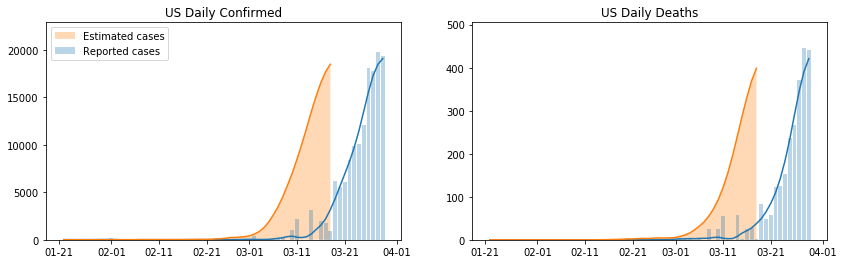

In [15]:
 
# make plot dataframe
df_pl = df_delta.groupby( 'Date').sum() 
df_pl['Date'] = df_pl.index  

fig, ax = plt.subplots(1 ,2,figsize=(14,4))

ax[0] = plot_daily( ax[0] , df_pl['Date'], df_pl['Daily Confirmed'] )
ax[1] = plot_daily( ax[1] , df_pl['Date'], df_pl['Daily Deaths'] )

ax[0].set_title('US Daily Confirmed')
ax[1].set_title('US Daily Deaths')  
ax[0].legend( )

In [16]:
# sort countries by confirmed cases on last date
bool_last = df_state['Date'] == df_state['Date'].max()
sorted_states = df_state[bool_last].sort_values(by=['Confirmed'], ascending=False )    
sorted_states.head(5)  
 

,State,Date,Active,Confirmed,Deaths,Recovered,Measure
728,New York,2020-03-29,0.0,59648.0,965.0,0.0,NaN
684,New Jersey,2020-03-29,0.0,13386.0,161.0,0.0,NaN
118,California,2020-03-29,0.0,5852.0,124.0,0.0,NaN
525,Michigan,2020-03-29,0.0,5488.0,132.0,0.0,NaN
507,Massachusetts,2020-03-29,0.0,4955.0,48.0,0.0,NaN


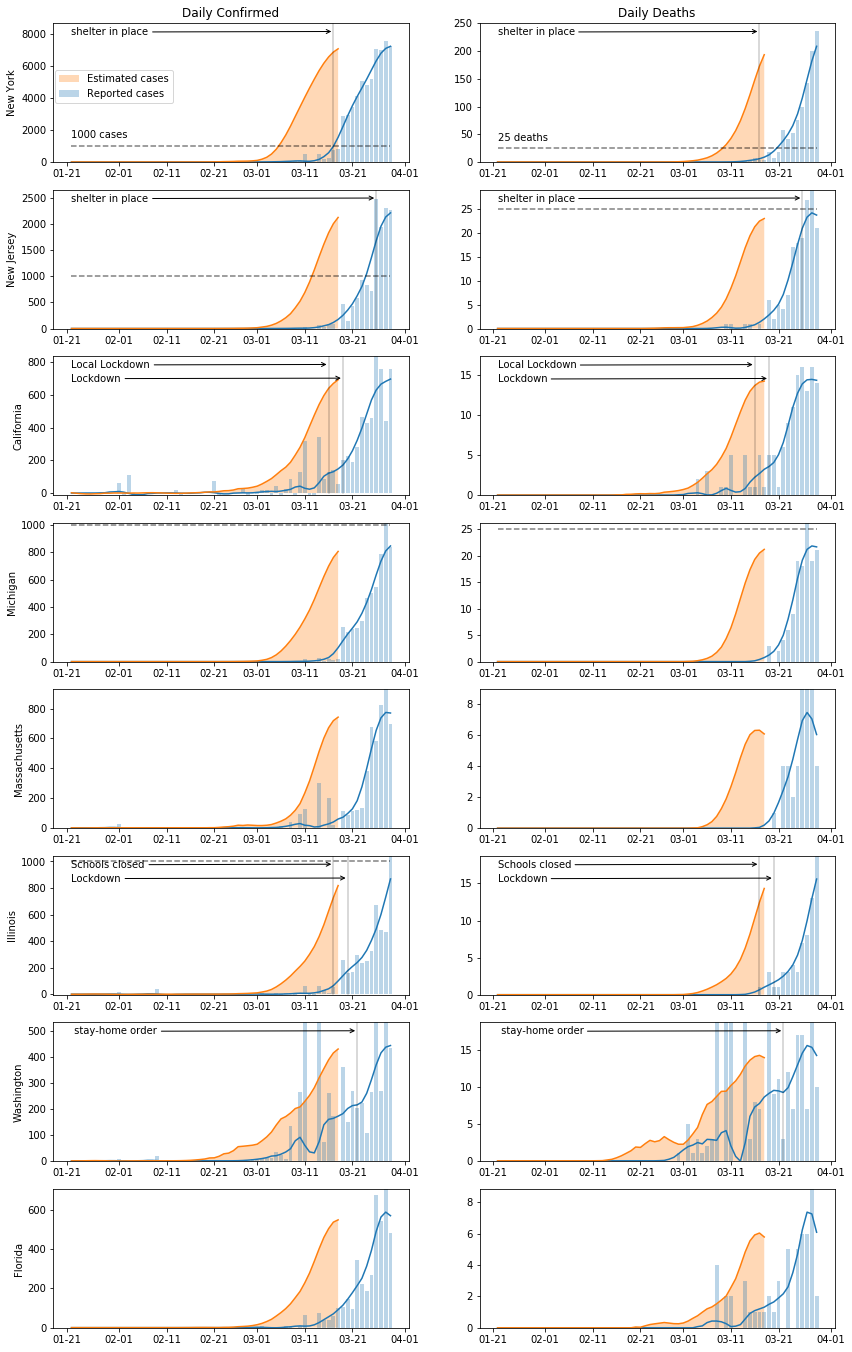

In [17]:
n_state = 8
top_state = sorted_states['State'][:n_state].tolist()

dates = df_pl['Date' ].unique() 
fig, ax = plt.subplots(n_state ,2,figsize=(14,n_state*3))

n_correction = 1

for i,country in enumerate( top_state ):
    df_pl = df_delta[ df_delta['State'] == country]
    
    bool_measure = df_pl['Measure'].notnull() 
    measures= df_pl.loc[bool_measure,['Measure','Date']] 
     
    plot_daily( ax[i,0] , df_pl['Date'], df_pl['Daily Confirmed'], measures)
    plot_daily( ax[i,1] , df_pl['Date'], df_pl['Daily Deaths'],measures)
 
    # add comparison lines  
    ax[i,0].plot( dates[[0,len(days)-1]], [1000,1000],'--',color='k', alpha = 0.5 )
    ax[i,1].plot( dates[[0,len(days)-1]], [25,25],'--',color='k', alpha = 0.5 ) 
    ax[i,0].set_ylabel( country )
       
ax[0,0].set_title('Daily Confirmed')
ax[0,1].set_title('Daily Deaths') 
ax[0,0].legend(  bbox_to_anchor=(0.35, .7))  
ax[0,0].annotate('1000 cases',[dates[0],1000*1.5])
ax[0,1].annotate('25 deaths',[dates[0],25*1.5])

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_states_dailycases'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  